In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 或者你找到的其他支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题


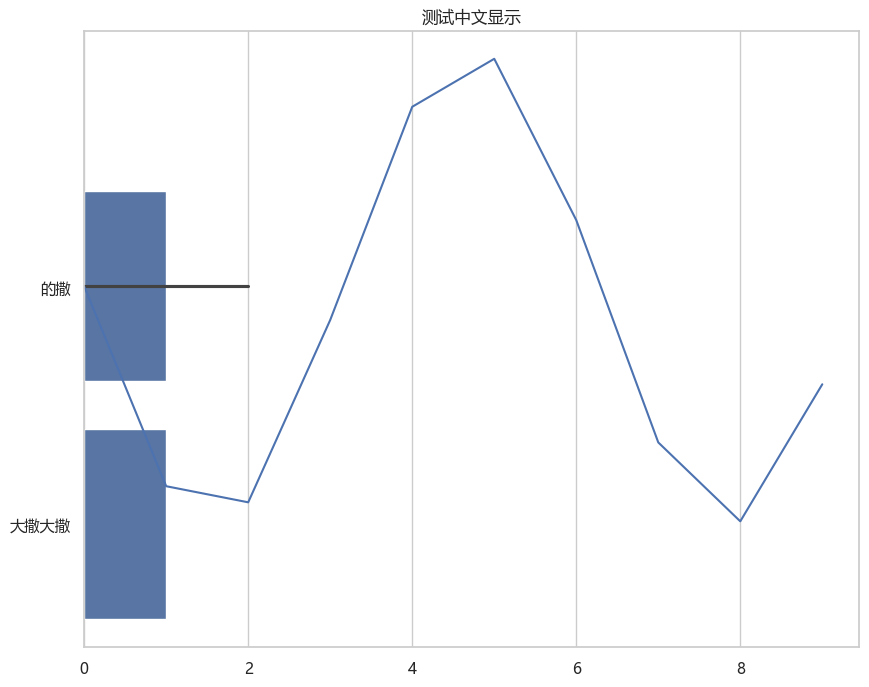

In [42]:
# 测试代码
def test_chinese_plot():
    # sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x=[0, 1, 2], y=['的撒', '大撒大撒', '的撒'])
    x = np.arange(10)
    y = np.sin(x)
    plt.plot(x, y)
    plt.title('测试中文显示')

test_chinese_plot()



In [52]:
def draw_fea(mean_across_cities, names):
    # 设置 seaborn 的风格
    # sns.set_theme(style="whitegrid")
    max_abs_value = np.max(np.abs(mean_across_cities))

    # 创建一个横向的条形图来显示特征的平均重要性
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x=mean_across_cities, y=names)

    # 设置标题和轴标签
    ax.set_xlim(-max_abs_value, max_abs_value)

    ax.set_title('Overall Mean Feature Importance (Scaled) of Each Feature')
    ax.set_xlabel('Overall Mean Feature Importance (Scaled by 10^-5)')
    ax.set_ylabel('Feature Name in Tensor 14')

    # 显示图形
    # plt.show()
    
def draw_fea_sorted(mean_across_cities, names):
    # 计算绝对值的最大值以确保横轴和纵轴的绝对值一致
    max_abs_value = np.max(np.abs(mean_across_cities))

    # 将特征标签和它们对应的平均重要性值结合在一起，以便排序
    features_with_values = list(zip(names, mean_across_cities))
    
    # 按照特征重要性的绝对值大小进行排序
    features_with_values.sort(key=lambda x: x[1], reverse=True)

    # 分离排序后的特征标签和它们对应的值
    sorted_labels, sorted_values = zip(*features_with_values)

    # 创建一个横向的条形图来显示排序后的特征的平均重要性
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x=np.array(sorted_values), y=np.array(sorted_labels))

    # 设置横轴的范围，使其与纵轴的范围绝对值一致
    ax.set_xlim(-max_abs_value, max_abs_value)

    # 设置标题和轴标签
    ax.set_title('Overall Mean Feature Importance (Scaled) of Each Feature')
    ax.set_xlabel('Overall Mean Feature Importance (Scaled by 10^-5)')
    ax.set_ylabel('Feature Name')

    # 显示图形
    # plt.show()

# 效仿captum的房价预测回归问题

In [44]:
import numpy as np
import pandas as pd
from os import path

#scikit-learn related imports
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

torch.manual_seed(42)
np.random.seed(42)


In [45]:
df = pd.read_csv('../dataset/tanjiaoyi/hb_carbon.csv', encoding='GBK', parse_dates=['date'], index_col='date').dropna()

feature_names = df.columns.drop('close').values
feature_names = feature_names.tolist()
print(feature_names)

X = df.drop(columns=['close']).values
y = df['close'].values
print(X.shape)
print(y.shape)

['kaipan', 'max', 'min', 'final', 'gasprice', 'coalprice', 'oilprice', 'hs300', 'deal_EUA', '英国布伦特原油现货价', 'INE原油期货收盘价(活跃合约)', 'INE原油期货结算价(活跃合约)', '路易斯安娜州亨利港天然气现货价', 'NYMEX天然气期货收盘价(连续)', 'IPE英国天然气期货结算价(活跃合约)', '纽卡斯尔NEWC动力煤现货价', '动力煤期货结算价(活跃合约)', '动力煤期货收盘价(活跃合约)', 'BOCE焦炭现货结算价', '焦炭期货结算价(活跃合约)', '焦炭期货收盘价(活跃合约)', '欧洲STOXX50价格指数(美元)', '欧洲STOXX600(美元)', '德国DAX', '英国富时100', '法国CAC40', '道琼斯工业指数', '标普500', '清洁能源', 'aql_sh', 'aql_gd', 'aql_hb', 'SI', 'Daily_EPU', 'FPU', 'MPU', 'TPU', 'ECPU']
(1856, 38)
(1856,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

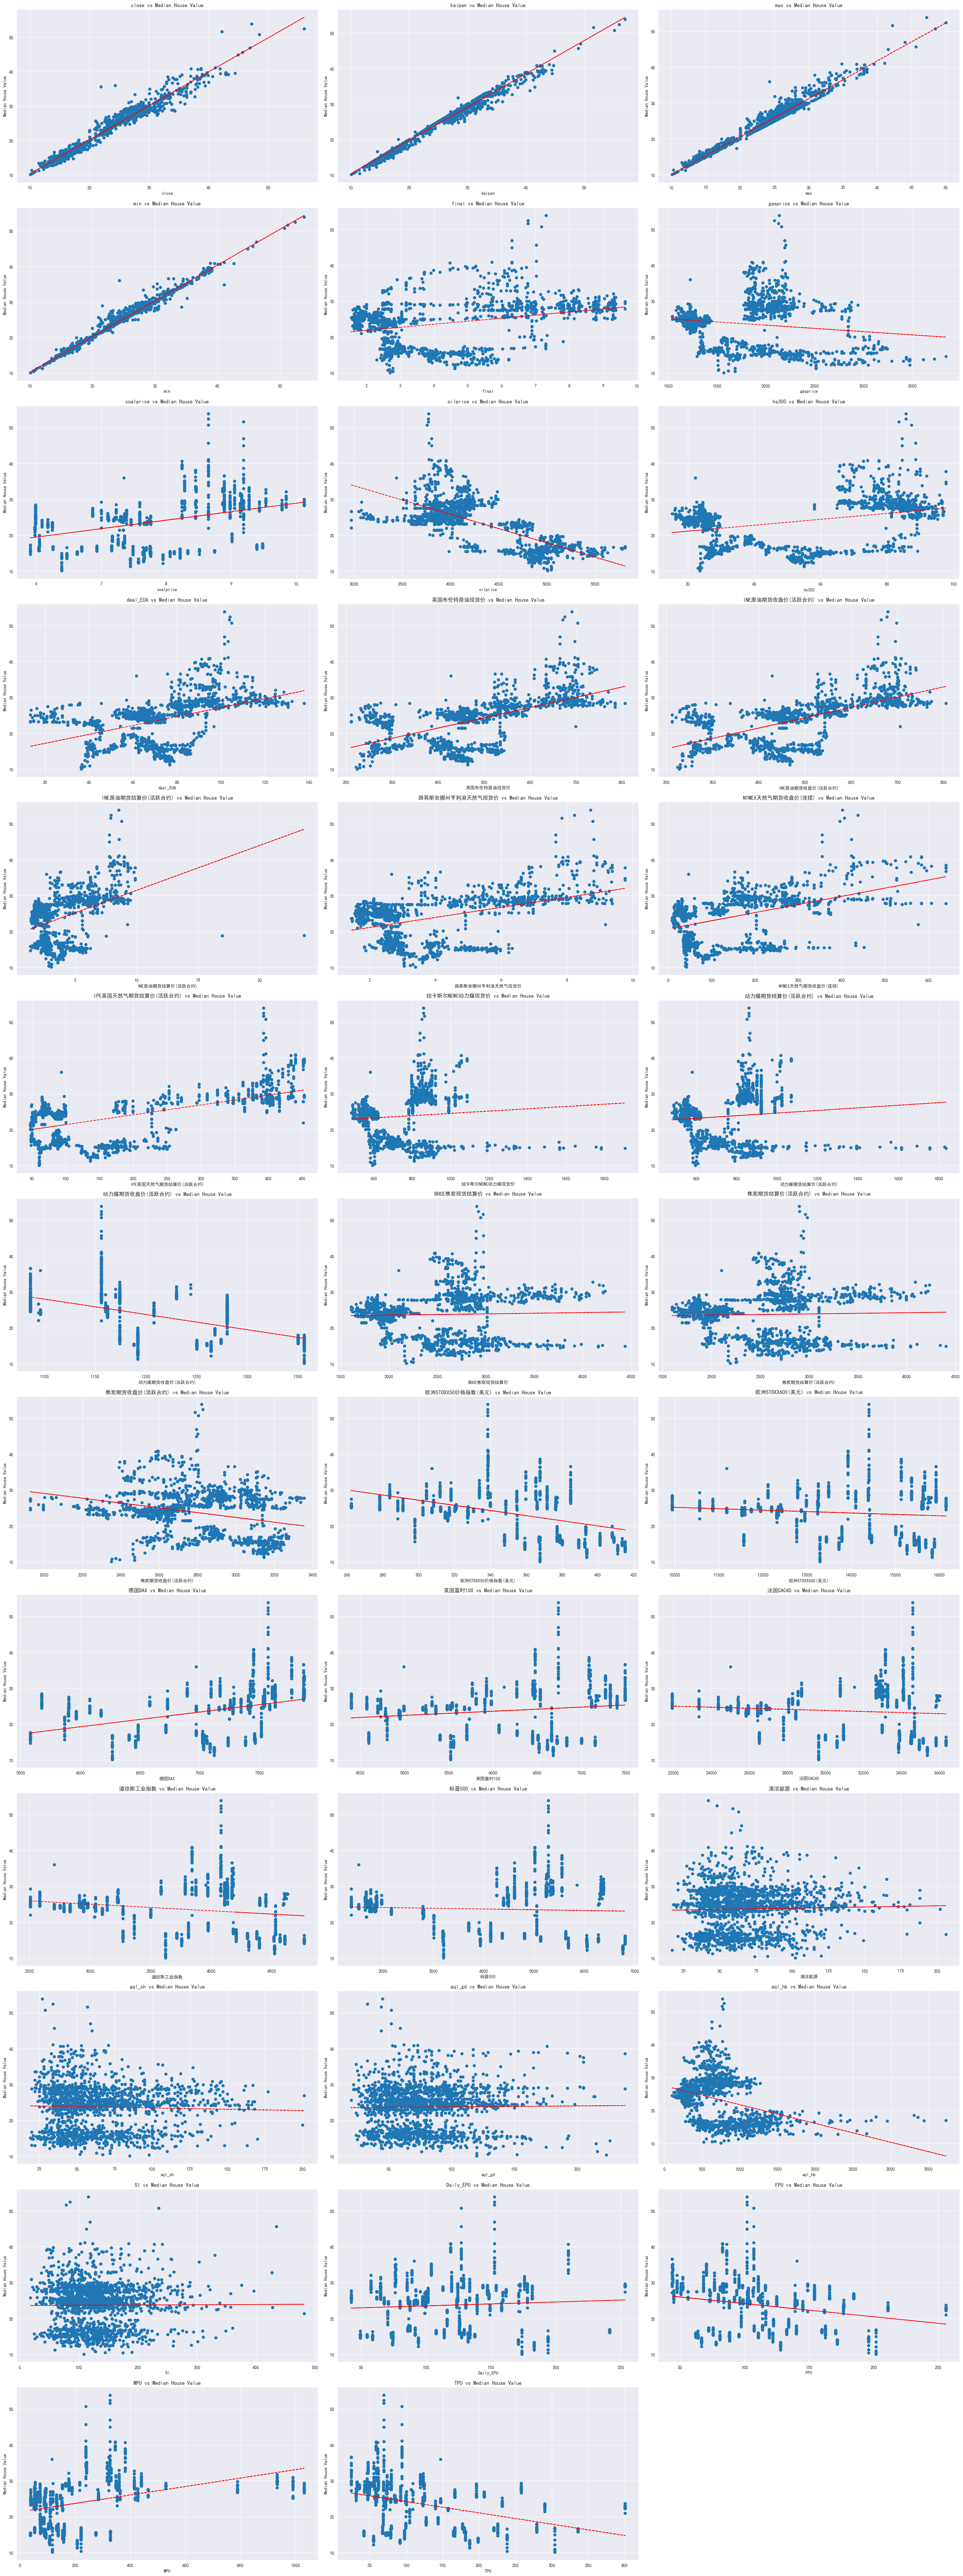

In [26]:
# 确定子图布局大小
rows = 13  # 子图的行数
cols = 3   # 子图的列数
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(30, 80))  # 调整为13行3列
for i, ax in enumerate(axs.flat):
    if i < len(feature_names) - 1:  # 确保不会超出特征数量
        x = X[:, i]
        pf = np.polyfit(x, y, 1)
        p = np.poly1d(pf)

        ax.plot(x, y, 'o')
        ax.plot(x, p(x), "r--")

        ax.set_title(feature_names[i] + ' vs Median House Value')
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel('Median House Value')
    else:
        ax.axis('off')  # 如果没有更多的特征要展示，隐藏剩余的子图

plt.tight_layout()
plt.show()

# 加载自己模型

In [46]:
from utils.util import load_dataloader
from models.model import GC_TCN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GC_TCN(num_node_features=30, gcn_hidden_dim=96, tcn_num_channels=[64, 32, 16], num_classes=1, kernel_size=2, dropout=0.2).to(device)
model.load_state_dict(torch.load("../checkpoints/DGCPN/38-hb-loss&da-1000.pth"))

train_loader, val_loader, test_loader = load_dataloader("../dataset/tanjiaoyi/dataloader-38/hb-dataloader.pth")

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.target_node_index).detach().cpu().numpy()
        all_predictions.extend(out)
        all_labels.extend(batch.y.cpu().numpy())
        
err = np.sqrt(mean_squared_error(all_predictions, all_labels))

print('model err: ', err)

model err:  0.054001026


In [47]:
batch = next(iter(train_loader)).detach().to(device)
x, edge_index, target_node_index = batch.x, batch.edge_index, batch.target_node_index
print(x.shape)

torch.Size([1482, 30])


# 使用FeaturePermutation

In [48]:
from captum.attr import FeaturePermutation

feature_perm = FeaturePermutation(model.forward)
attributions = feature_perm.attribute(inputs=(x, edge_index, target_node_index), target=None, show_progress=True)

Feature Permutation attribution:   0%|          | 0/1066 [00:00<?, ?it/s]

In [49]:
print(type(attributions))
print(attributions[0].shape)

fa_attr_test_sum = attributions[0].detach().cpu().numpy().sum(1)    
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

<class 'tuple'>
torch.Size([38, 30])


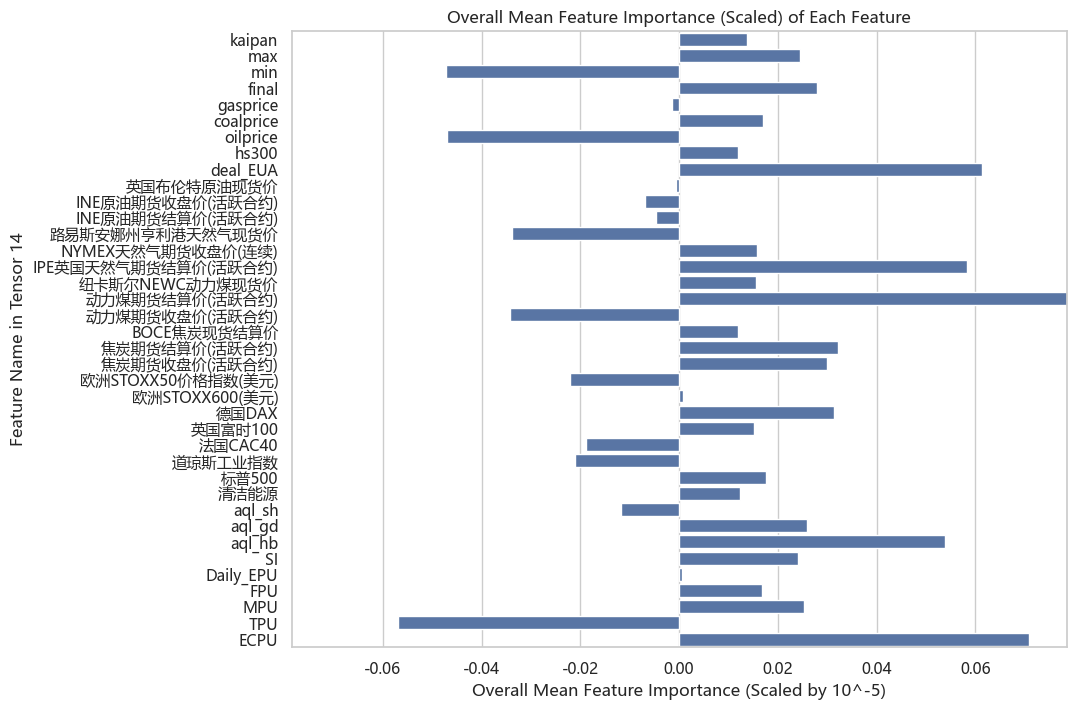

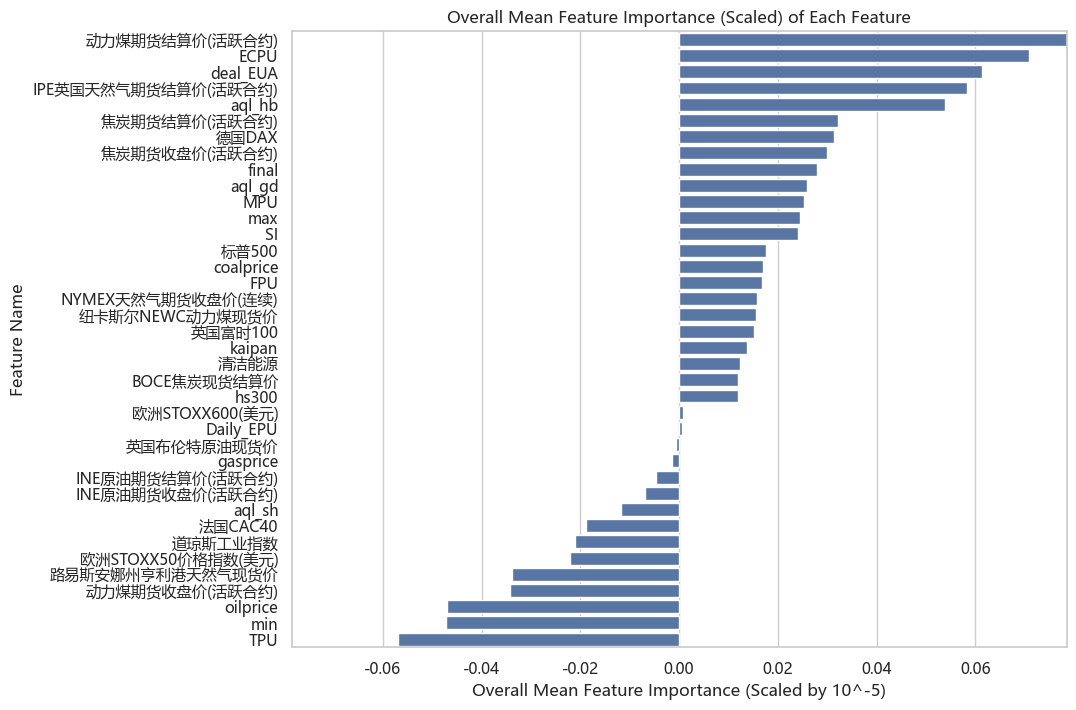

In [53]:
# draw_fea(fa_attr_test_sum)  # 绘制特征重要性
draw_fea(fa_attr_test_norm_sum, feature_names)  # 绘制特征重要性
draw_fea_sorted(fa_attr_test_norm_sum, feature_names)

In [6]:
from captum.attr import FeatureAblation

feature_ablation = FeatureAblation(model.forward)
attributions = feature_ablation.attribute(inputs=(x, edge_index, target_node_index), target=None, show_progress=True)


Feature Ablation attribution:   0%|          | 0/1832 [00:00<?, ?it/s]

In [11]:
print(type(attributions))
print(attributions[0].shape)

fa_attr_test_sum = attributions[0].detach().cpu().numpy().sum(1)    
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

<class 'tuple'>
torch.Size([64, 30])


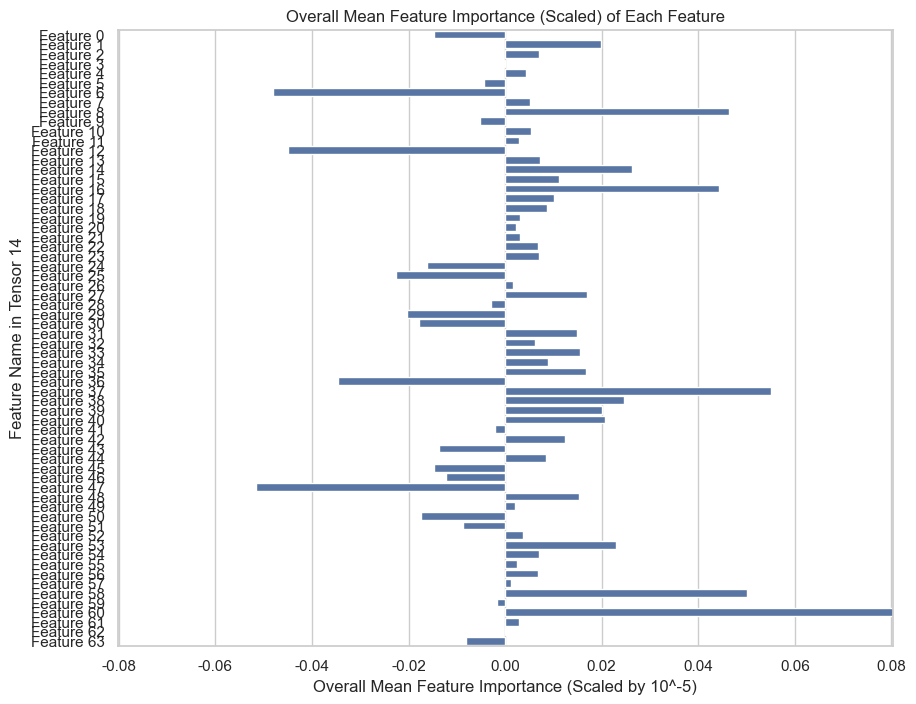

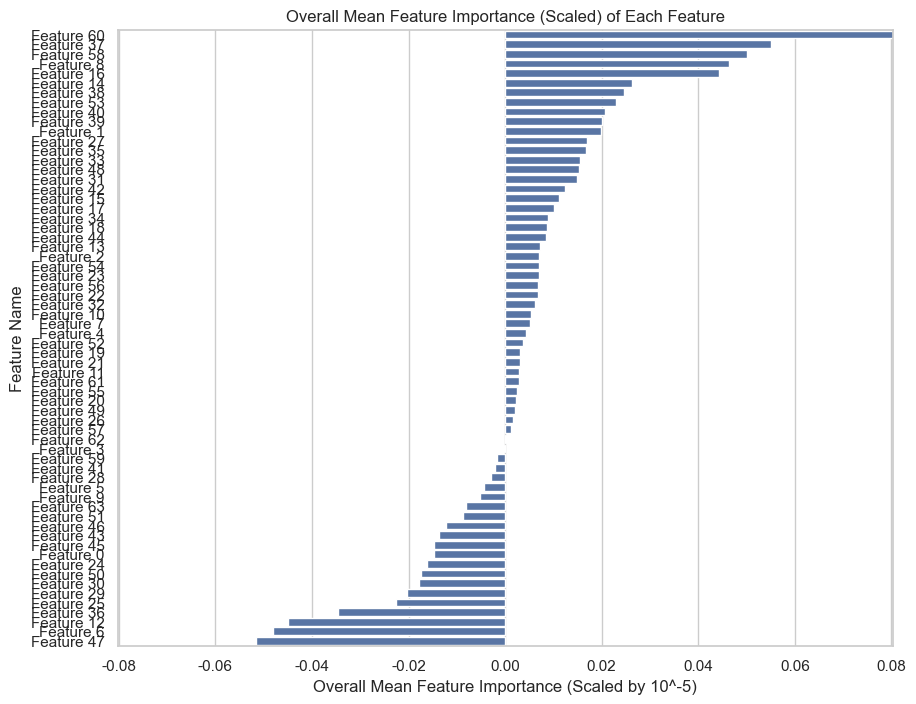

In [12]:
draw_fea(fa_attr_test_norm_sum, feature_names)  # 绘制特征重要性
draw_fea_sorted(fa_attr_test_norm_sum, feature_names)